In [8]:
%pip install tensorflow split-folders[full]

^C
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
import splitfolders

In [10]:
RANDOM_SEED = 69
BATCH_SIZE  = 32
EPOCHS      = 10
IMAGE_SIZE  = (224, 224)
LABEL_MODE  = "categorical"
AUGMENTATION_FACTOR = 0.2
TRAIN_DIR   = "dataset_splitted/train"
TEST_DIR    = "dataset_splitted/val"
TAGS = [
    "animal", "car", "cloud", "dance", "fire", "flower", "food", "sunset", "water"
]

In [ ]:
splitfolders.ratio("dataset", output="dataset_splitted", seed=RANDOM_SEED, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 5603 files [00:35, 156.79 files/s]


Image shape: (224, 224, 3)


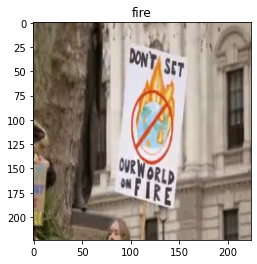

In [11]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_random_image_from_dataset(target_dir, class_names):
    if not target_dir:
        print("Please path a directory!")
        return

    if not os.path.isdir(target_dir):
        print("This directory path does not exist!")
        return
    
    # Setup target directory (we'll view images from here)
    target_class = random.choice(class_names)
    target_folder: str = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)

    print(f"Image shape: {img.shape}") # show the shape of the image

show_random_image_from_dataset(target_dir=f"{TRAIN_DIR}/", class_names=TAGS)

In [12]:
print("training data 🧠:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    image_size=IMAGE_SIZE,
    seed=RANDOM_SEED,
    shuffle=True
)

print("test data 🧪:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    image_size=IMAGE_SIZE,
    seed=RANDOM_SEED,
    shuffle=False
)

training data 🧠:
Found 4481 files belonging to 9 classes.
test data 🧪:
Found 1122 files belonging to 9 classes.


In [13]:
from tensorflow.keras.layers import Dense, RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.activations import softmax


augmentaion_layer = Sequential([
    RandomFlip("horizontal", seed=RANDOM_SEED),
    RandomRotation(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomZoom(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomHeight(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomWidth(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    Rescaling(1/255.)
])
augmentaion_layer

dataset_splitted/train/dance/image_100_7.jpg


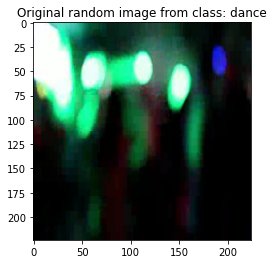

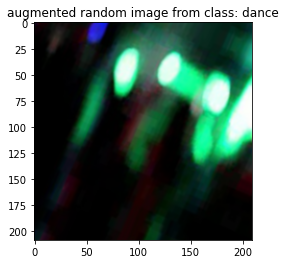

In [14]:
def show_image_after_augmentation_layer(target_dir, class_names, augmentation_layer, scale= True):
    """_summary_

    Args:
        target_dir (str): _description_
        class_names (List[str]): _description_
        augmentation_layer (tf.keras.sequential.Sequential): _description_
    """
    target_class = random.choice(class_names)
    target_dir = f"{target_dir}/{target_class}"
    random_image = random.choice(os.listdir(target_dir))
    random_image_path = target_dir + "/" + random_image

    print(random_image_path)
    # Read in the random image
    img = mpimg.imread(random_image_path)
    plt.title(f"Original random image from class: {target_class}")
    # plt.axis(False)
    plt.imshow(img);

    # Now lets plot our augmented random image
    augmented_image = augmentation_layer(img, training=True)
    plt.figure()
    plt.title(f"augmented random image from class: {target_class}")
    if scale:
        plt.imshow(augmented_image / 255)
    else:
        plt.imshow(augmented_image)

show_image_after_augmentation_layer(target_dir=TRAIN_DIR, class_names=TAGS, augmentation_layer=augmentaion_layer, scale=False)

In [15]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,), name="input_layer")
x = augmentaion_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
output_layer = Dense(len(TAGS), activation=softmax, name="output_layer")(x)

model_1 = tf.keras.Model(input_layer, output_layer)

In [16]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [17]:
model_checkpoint_path = "checkpoint/checkpoint.cpk"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [18]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"

    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + \
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


In [19]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, 3)           0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 9)                 18441     
                                                                 
Total params: 23,583,241
Trainable params: 18,441
Non-trainable params: 23,564,800
____________________________________________

In [20]:
history_1 = model_1.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        tf.keras.callbacks.CSVLogger("history/history.csv"),
        checkpoint_callback,
        create_tensorboard_callback(dir_name="tensorboard", experiment_name="vitya")
    ]
)

Saving TensorBoard log files to: tensorboard/vitya/20221128-133749
Epoch 1/10
102/141 [====================>.........] - ETA: 46s - loss: 1.2931 - accuracy: 0.5588

KeyboardInterrupt: 

In [ ]:
eval_1 = model_1.evaluate(test_data)
eval_1

NameError: name 'model_1' is not defined

In [ ]:
model_1.save("vitya_model.h5")

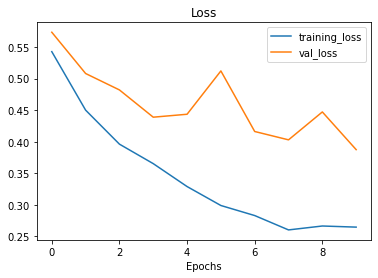

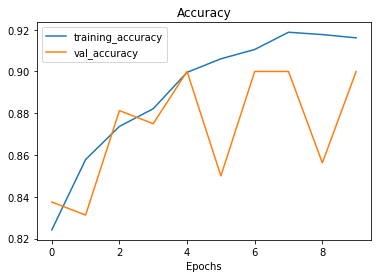

In [ ]:
def plot_loss_curves(history, metric="accuracy"):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history[metric]
    val_accuracy = history.history[f"val_{metric}"]

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history=history_1)

In [ ]:
preds_probs = model_1.predict(test_data)
preds_probs

36/36 [==============================] - 39s 1s/step


array([[9.7874099e-01, 2.3143566e-03, 7.9885242e-05, ..., 6.0407115e-06,
        5.5109781e-06, 8.1804087e-03],
       [9.7453147e-01, 1.4950570e-02, 3.0387554e-03, ..., 1.9813908e-04,
        8.1982420e-05, 4.5818118e-03],
       [9.9923158e-01, 1.8820925e-04, 8.1958456e-07, ..., 1.4035327e-07,
        5.7528946e-06, 4.3224948e-04],
       ...,
       [3.3362501e-04, 1.6808137e-07, 3.2780485e-04, ..., 7.3866784e-07,
        3.0760631e-08, 9.9933380e-01],
       [2.6395967e-02, 4.3791770e-05, 1.7000027e-02, ..., 7.2167468e-06,
        1.2101307e-06, 9.5623481e-01],
       [1.8859345e-02, 1.4001234e-05, 1.6080912e-02, ..., 4.5065437e-05,
        7.0023930e-07, 9.6478802e-01]], dtype=float32)

In [ ]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
def get_predicted_labels_from_test_data(test_data):
    """return real labels (or y labels) from test_data (test_data must be BatchDataset)

    Args:
        test_data (Any): test data

    Returns:
        _type_: currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
    """
    y_labels = []
    for images, labels in test_data.unbatch():
        y_labels.append(labels.numpy().argmax())
    return y_labels

y_labels = get_predicted_labels_from_test_data(test_data=test_data)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.9064171122994652

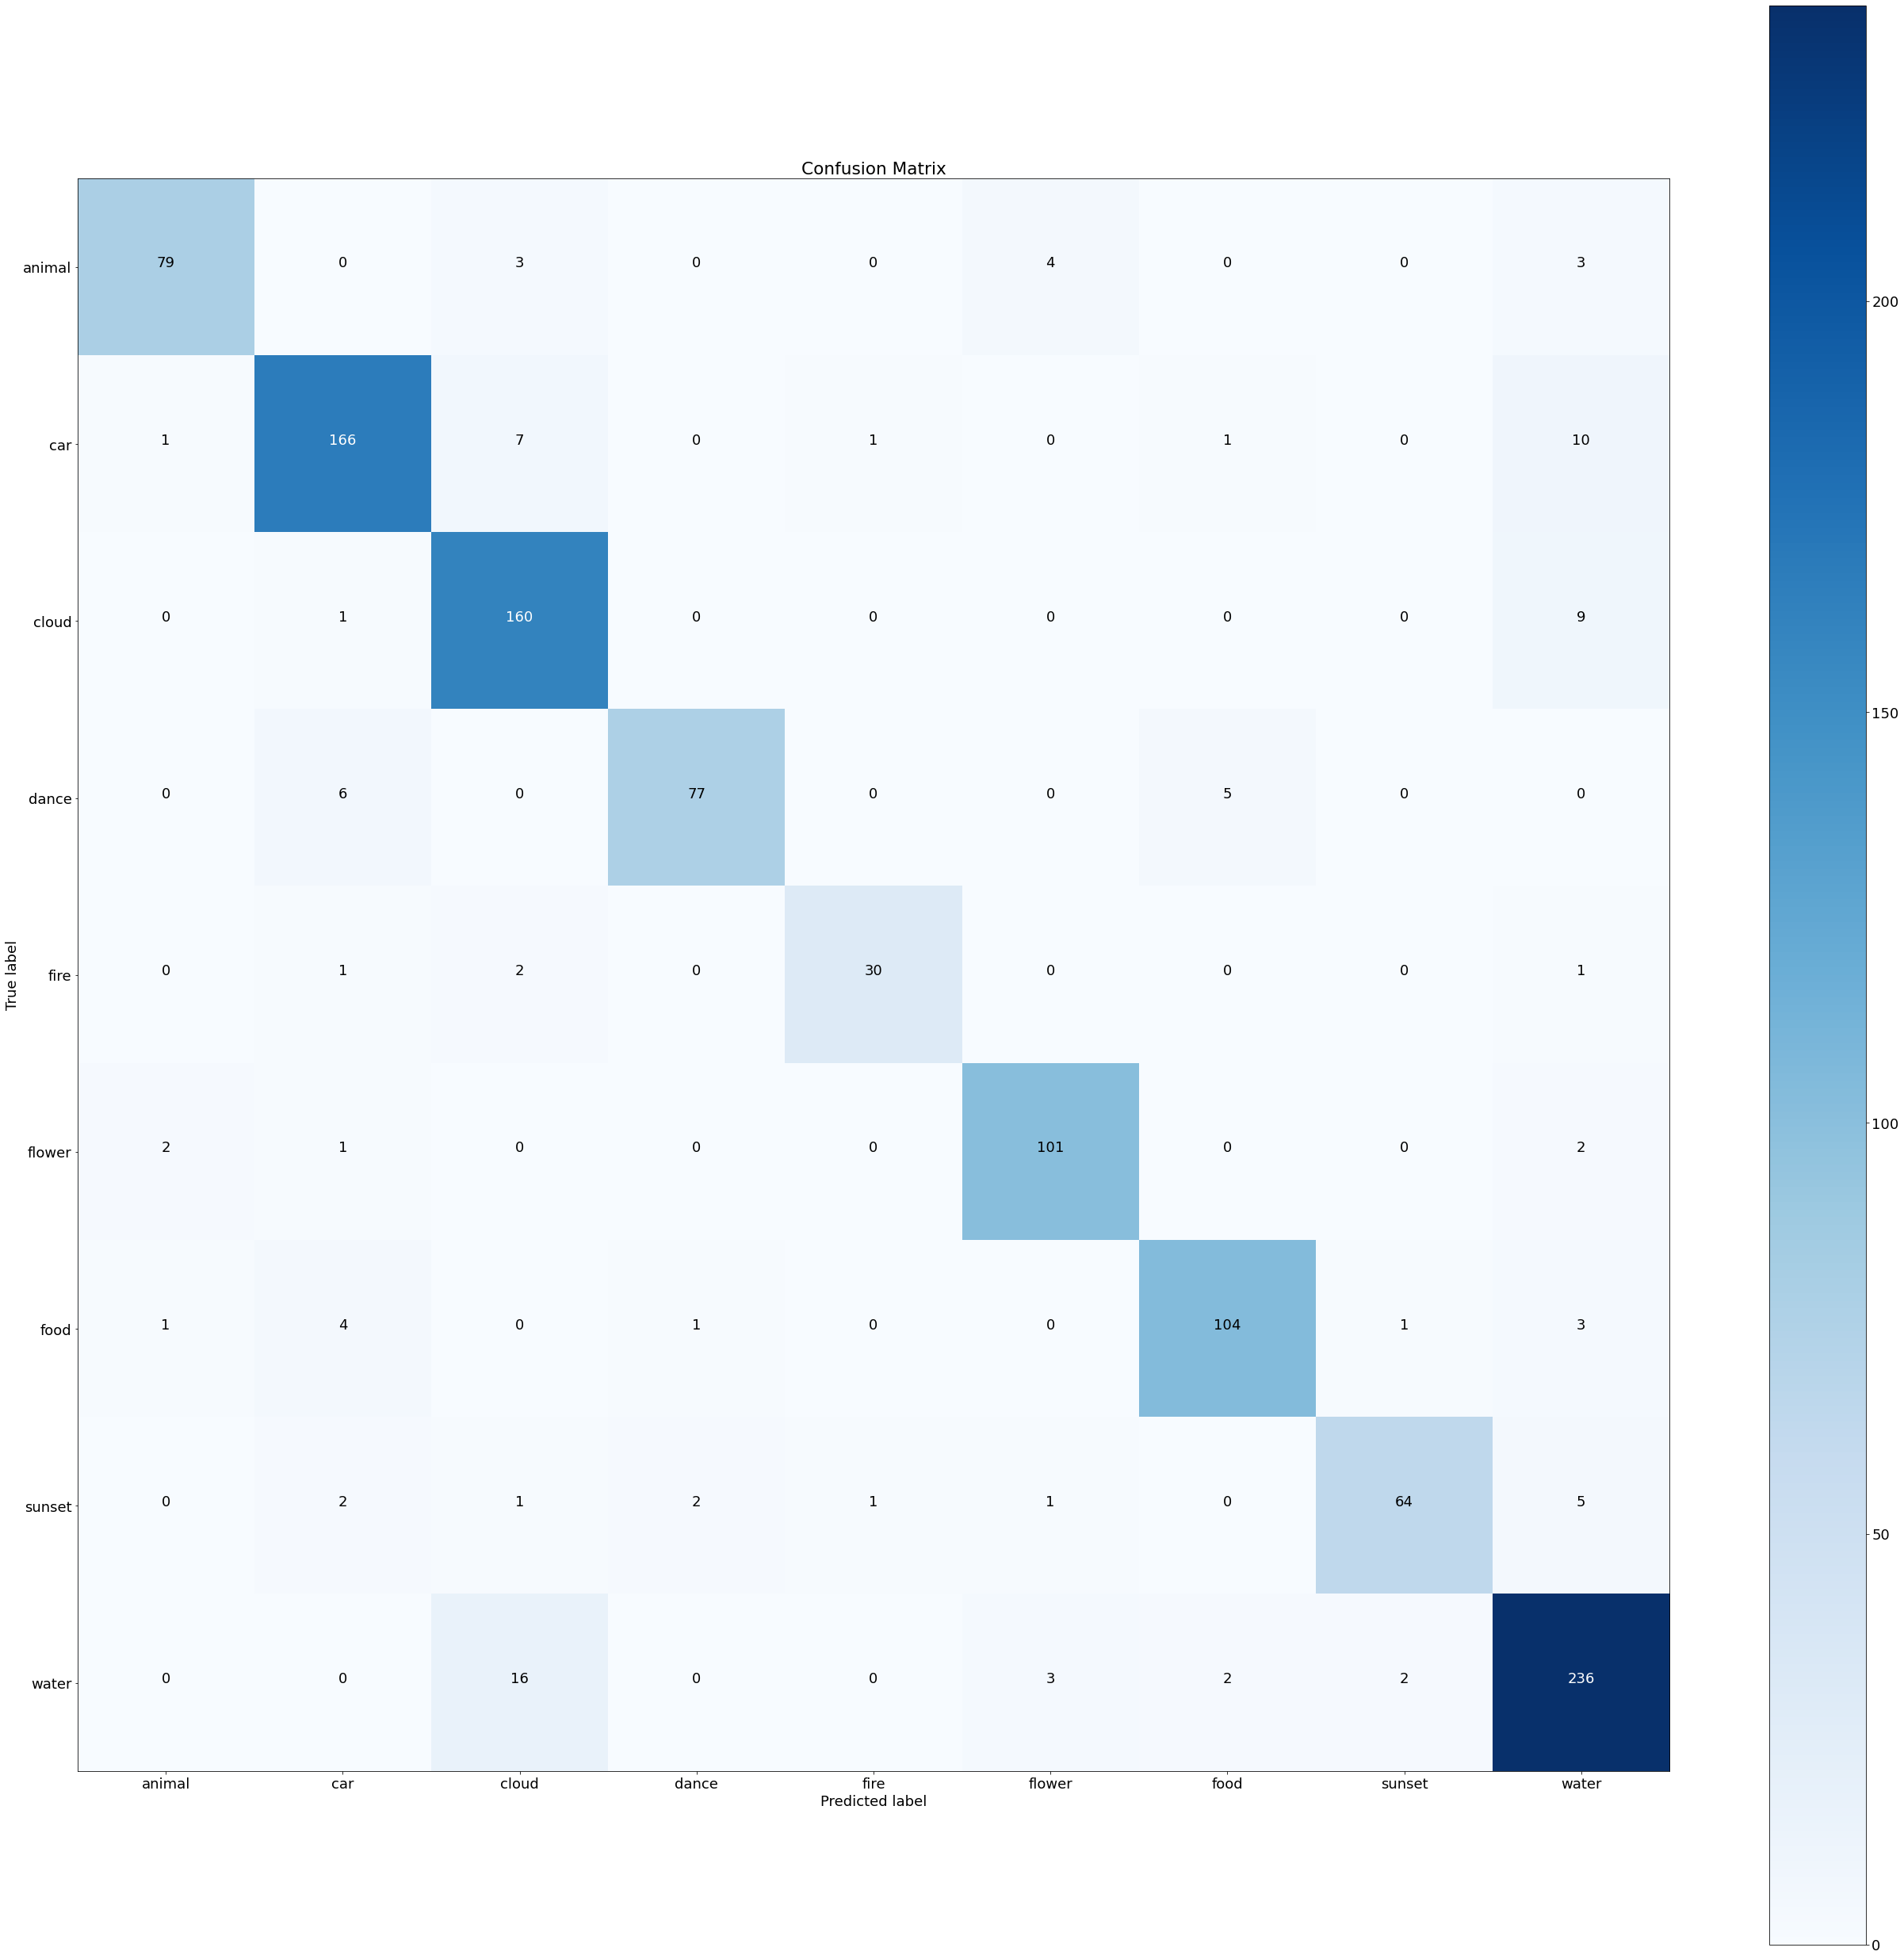

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    plt.rcParams.update({"font.size": text_size})
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / \
        cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    # colors will represent how 'correct' a class is, darker == better
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           # create enough axis slots for each class
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           # axes will labeled with class names (if they exist) or ints
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(45, 45),
                      text_size=18)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        89
           1       0.92      0.89      0.90       186
           2       0.85      0.94      0.89       170
           3       0.96      0.88      0.92        88
           4       0.94      0.88      0.91        34
           5       0.93      0.95      0.94       106
           6       0.93      0.91      0.92       114
           7       0.96      0.84      0.90        76
           8       0.88      0.91      0.89       259

    accuracy                           0.91      1122
   macro avg       0.92      0.90      0.91      1122
weighted avg       0.91      0.91      0.91      1122



In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

def get_f1_score_on_every_class_name(y_labels, y_true, class_names):
    """Return f1 score on every class name as a dataframe

    Args:
        y_labels (_type_): y_true of test_
        y_pred (_type_): predictions list

    Returns:
        pd.DataFrame: f1-scores dataframe on every class name
    """
    classification_report_dict = classification_report(y_labels, y_true, output_dict=True)
    # Create empty dictionary
    class_f1_scores = {}
    # Loop through classification report dictionary items
    for k, v in classification_report_dict.items():
        if k == "accuracy": # stop once we get to accuracy key
            break
        else:
            # Add class names and f1-scores to new dictionary
            class_f1_scores[class_names[int(k)]] = v["f1-score"]
    class_f1_scores

    # Trun f1-scores into dataframe for visualization
    f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                            "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
    return f1_scores

f1_scores = get_f1_score_on_every_class_name(y_labels=y_labels, y_true=pred_classes, class_names=class_names)
f1_scores

,class_names,f1-score
5,flower,0.939535
6,food,0.920354
0,animal,0.918605
3,dance,0.916667
4,fire,0.909091
1,car,0.904632
7,sunset,0.895105
8,water,0.893939
2,cloud,0.891365


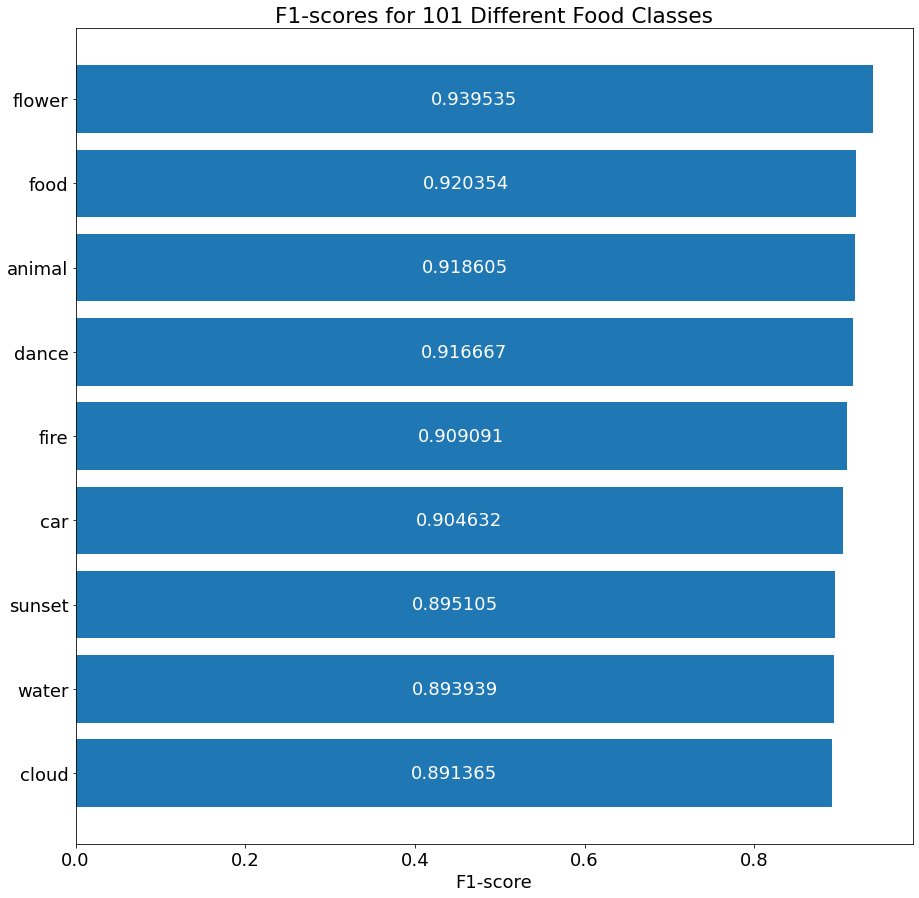

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_f1_scores_on_every_class_name(f1_scores, figsize = (10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
    ax.bar_label(scores, label_type='center', c="white")
    ax.set_yticks(range(len(f1_scores)))
    ax.set_yticklabels(f1_scores["class_names"])
    ax.set_xlabel("F1-score")
    ax.set_title("F1-scores for 101 Different Food Classes")
    ax.invert_yaxis(); # reverse the order of our plot

plot_f1_scores_on_every_class_name(f1_scores=f1_scores, figsize=(15, 15))

In [ ]:
import os
import random


def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img


def make_random_prediction(class_names, test_dir, qty: int = 3, figsize =(17, 10), fontsize: int = 12, image_shape=224):
    plt.figure(figsize=figsize)
    for i in range(qty):
        # Choose random image(s) from random class(es)
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(test_dir + "/" + class_name))
        filepath = test_dir + "/" + class_name + "/" + filename
        
        # Load the image and make predictions
        print("filepath:", filepath)
        img = load_and_prep_image(filepath, scale=False, img_shape=image_shape)
        print("before:", img.shape)
        img_expanded = tf.expand_dims(img, axis=0)
        print("after: ", img_expanded.shape)
        pred_prob = model_1.predict(img_expanded) # get prediction probabilities array
        pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

        # Plot the image(s)
        plt.subplot(1, qty, i+1)
        # print(img)
        plt.imshow(img/225.)
        if class_name == pred_class: # if predicted class matches truth class, make text green
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontdict= {'fontsize': fontsize})
        plt.axis(False);

make_random_prediction(TAGS, test_dir=TEST_DIR, fontsize=10, qty=3, image_shape=224) 

NameError: name 'TAGS' is not defined

In [ ]:
image = load_and_prep_image("photo_2022-08-01_00-01-44.jpg")
image_expanded = tf.expand_dims(image, axis=0)
pred_prob = model_1.predict(image_expanded)

NameError: name 'load_and_prep_image' is not defined